In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector

In [2]:
n = 6  # Maximum length of a input
N = 2**n # Total number of inputs (Domain)
X = range(N) # Domain of hash function
hash_bits = 5 # Maximum length of hash

A collision for function $F : X → Y$ consists of two distinct elements $x_0, x_1 ∈ X$ such that $F(x_0) = F(x_1)$.

In [3]:
def gen_hash(in_bits = 4,hash_bits = 4):
    """ Generates a hash function
    
    Args:
        in_bits (int): Maximum number of bits in input
        hash_bits (int): Maximum number of bits in hash
    Returns:
        hash_map (dict): Hash function
    """
    hashes = []
    
    in_range = 2**in_bits 
    out_range = 2**hash_bits
    
    # Hash function with modulo
    for i in range(in_range):
        hashes.append(i%out_range)
    
    # Shuffle the hash outputs
    hashes = np.random.permutation(hashes)
    
    # Create the hash map dictionary
    hash_map = { i: hashes[i] for i in range(in_range)}
    return hash_map

In [4]:
hash_fn = gen_hash(n, hash_bits)
hash_fn

{0: 4,
 1: 4,
 2: 16,
 3: 14,
 4: 2,
 5: 11,
 6: 30,
 7: 23,
 8: 11,
 9: 10,
 10: 12,
 11: 8,
 12: 26,
 13: 20,
 14: 20,
 15: 25,
 16: 3,
 17: 31,
 18: 0,
 19: 1,
 20: 27,
 21: 18,
 22: 28,
 23: 0,
 24: 21,
 25: 25,
 26: 6,
 27: 2,
 28: 21,
 29: 17,
 30: 23,
 31: 10,
 32: 18,
 33: 31,
 34: 28,
 35: 5,
 36: 24,
 37: 3,
 38: 8,
 39: 29,
 40: 6,
 41: 14,
 42: 1,
 43: 27,
 44: 13,
 45: 30,
 46: 26,
 47: 15,
 48: 22,
 49: 17,
 50: 15,
 51: 13,
 52: 19,
 53: 16,
 54: 19,
 55: 5,
 56: 9,
 57: 7,
 58: 9,
 59: 7,
 60: 24,
 61: 22,
 62: 12,
 63: 29}

Pick an arbitrary subset $K \subset X$ of cardinality $k = \sqrt[3]{N}$.

In [5]:
k = int(np.ceil(np.cbrt(N)))
K = np.random.choice(X, k, replace=False)
K

array([15, 33,  5, 20])

Construct a table $L$ of size $k$ where each item in $L$ holds a distinct pair $(x, F(x))$ with $x ∈ K$. Sort $L$ according to the second entry in each item of $L$.

In [6]:
L = [ (i, hash_fn[i]) for i in K]
L.sort(key = lambda x: x[1])
L

[(5, 11), (15, 25), (20, 27), (33, 31)]

Check if $L$ contains a collision, that is, check if there exist distinct elements $(x_0, F(x_0)),(x_1, F(x_1)) ∈ L$ for which $F(x_0) = F(x_1)$.

In [7]:
flag = False
for i in range(1,k):
    if L[i-1][1] == L[i][1]: # Hashes are equal
        print("Collision Found")
        print(L[i-1], L[i])
        flag = True
        break
if flag == False:
    print("No Collision Found")

No Collision Found


Compute $x_1 = Grover(H, 1)$ where $H : X → \{0, 1\}$ denotes the function defined by $H(x) = 1$ if and only if there exists $x_0 ∈ K$ so that $(x_0, F(x)) ∈ L$ but $x \not = x_0$. (Note that $x_0$ is unique if it exists since we already checked that there are no collisions in $L$).

In [10]:

def search(x, hash_x):
    """
    Check whether there exists x_0 ∈ K so that (x_0, F(x)) ∈ L but x not = x_0.
    Since L is sorted by hashes we use binary search on L.  

    Args:
        x (int): Input x
        hash_x (int): Hash of x
    Returns:
        index (int): Returns the index of x_0 if found, else -1
    
    """
    low = 0
    high = k-1
    
    while low <= high:
        mid = (low + high)//2
        
        # (x_0, F(x)) ∈ L but x not = x_0
        if (L[mid][1] == hash_x) and (x != L[mid][0]):
            return L[mid][0]
        elif (L[mid][1] < hash_x):
            low = mid + 1
        else:
            high = mid - 1
    return -1

def H_mat():
    """ 
    Creates a unitary matrix for H: X -> {0, 1}  
    """
    
    size = 2**(n+1) # Since |X| = n, we need n+1 qubits
    U = np.zeros((size, size)) # Initialize the matrix
    
    for i in range(size):
        
        x = i&(2**n-1) # Get x from the first n bits
        hash_x = hash_fn[x] # Compute the hash of x
        
        x0 = search(x, hash_x) 
        
        if x0 == -1:
            U[i][i] = 1
        else:
            U[i^(2**n)][i] = 1
    
#     print(U)
    qc = QuantumCircuit(n+1)
    qc.unitary(U,range(n+1))
    return qc.to_gate()


Inverse about the mean gate required for grover search

In [11]:
def inv_mean(n):
    """
    Creates a unitary matrix for inv_mean: X -> {0, 1}
    Args:
        n (int): Maximum number of bits in input
    Returns:
        inv_mean (QuantumCircuit): inv_mean unitary matrix
    """
    size = 2**(n)
    A = np.full((size,size), 1/size)
    I = np.identity(size)
    inv_mat = -I + 2*A
    qc = QuantumCircuit(n)
    qc.unitary(inv_mat,range(n))
    return qc.to_gate()

Compute $x_1 = Grover(H, 1)$ i.e. find $x \in X$ such that $H(x) = 1$

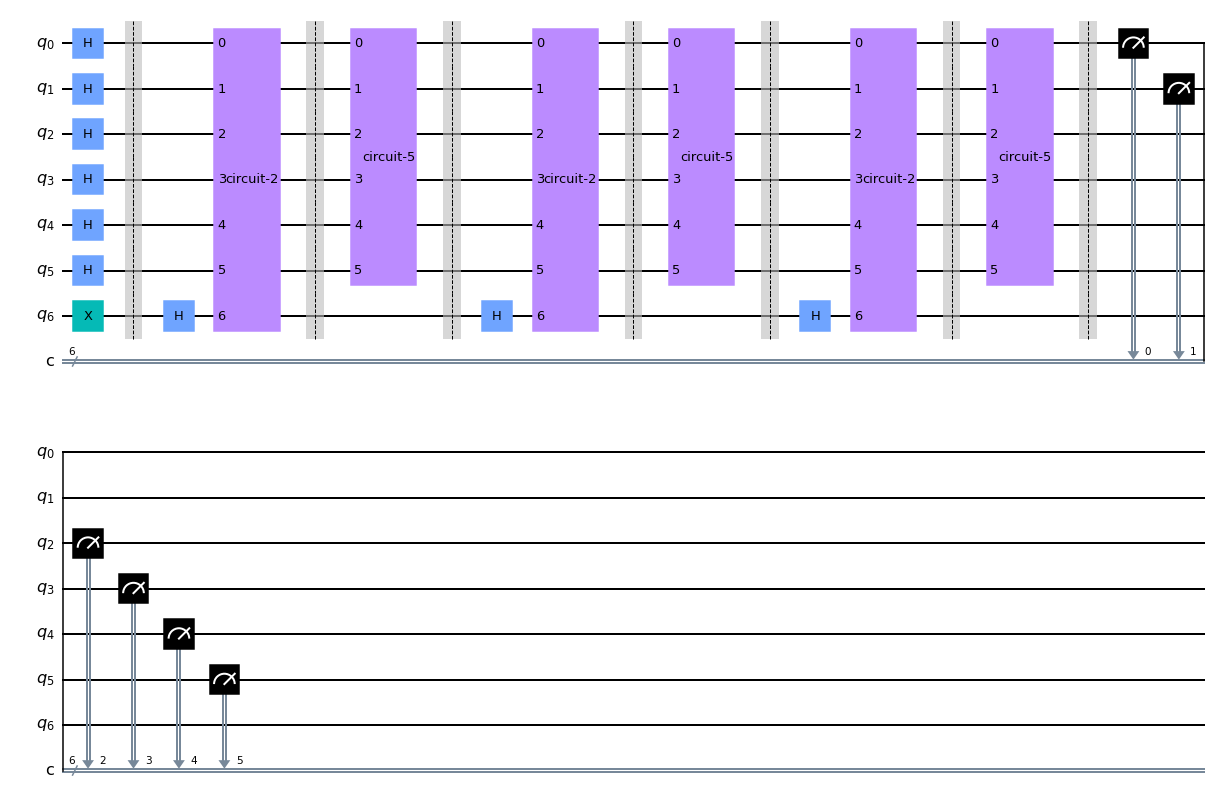

In [12]:
qc = QuantumCircuit(n+1,n)

qc.x(n)
for i in range(n):
    qc.h(i)
    
qc.barrier()

Uf = H_mat()
inv_gate = inv_mean(n)

num_iterations = int((np.pi/4) * np.ceil(np.sqrt((N)/k)))

for i in range(num_iterations):
    # Phase Inversion
    qc.h(n)
    
    qc.append(Uf, range(n+1))
    qc.barrier()

    # Inversion about mean
    qc.append(inv_gate, range(n))
    qc.barrier()


for i in range(n):
    qc.measure(i,i)

qc.draw('mpl')

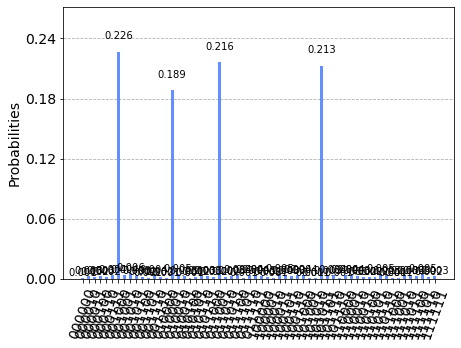

In [13]:
shots = 1000
simulator = Aer.get_backend('qasm_simulator')
res = execute(qc,backend=simulator, shots=shots).result()
counts = res.get_counts(qc)
plot_histogram(counts)

Find $(x_0, F(x_1)) ∈ L$.  Output the collision $\{x0, x1\}$

In [14]:
x = [int(i,2) for i in res.get_counts(qc).keys()]
collisions = []
for i in x:
    hash_i = hash_fn[i]
    x0 = search(i,hash_i)
    if x0 != -1:
        collisions.append((x0,i, hash_i))

In [15]:
collisions

[(5, 8, 11), (15, 25, 25), (20, 43, 27), (33, 17, 31)]